# Practical Issues

In this notebook we'll go through the process of scanning a model with more production-like characteristics.
Specifically we'll show how to deal with:

1. Dataset one-hot encoding by ETL pipelines
2. Bucketing numeric features to define fairness groups

In [1]:
import pandas as pd
import matplotlib as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from copy import copy

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue,
                                      CertifaiFeatureRestriction, CertifaiGroupingBucket,
                                      CertifaiFeatureDataType, CertifaiFeatureSchema, CertifaiDataSchema)
from certifai.scanner.report_utils import scores, construct_scores_dataframe
from certifai.common.utils.encoding import CatEncoder

## Dataset and ETL

We'll use the 'adult income' dataset, and build a simple model to predict whether an individual earns more or
less than $50k.

In a production setting, models may often be trained from previously pre-processed data, so to simulate this
we'll first pre-process the dataset to encode its categorical features as one-hots, and save off that pre-processed data, which we'll then go on to use to both train a model and subsequently analyse that model using
Certifai.

In [2]:
# Example will use a simple logistic classifier on the German Credit dataset
base_path = '..'
all_data_file = f"{base_path}/datasets/adult_income_eval.csv"
preprocessed_dataset_file = "preprocessed.csv"

df = pd.read_csv(all_data_file)

display(df[:2])

# Encode the categorical columns as one-hots
cat_columns = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'gender',
    'native-country'
    ]
label_column = 'income'

encoded_df = pd.get_dummies(df, columns=cat_columns)

display(encoded_df[:2])

# We will also want to know how the categorical encoding has mapped categorical values to columns, so
# save this as a dictionary for later use (if the data were given to us pre-encoded then we'd need
# to construct this mapping manually based on manual analysis of the data or a schema definition also given
# to us with the dataset)
cat_value_mappings = {}
for feature in cat_columns:
    one_hot_col_name_prefix = f"{feature}_"
    mapping = {}
    for ec in encoded_df.columns:
        if ec.startswith(one_hot_col_name_prefix):
            value = ec[len(one_hot_col_name_prefix):]
            mapping[ec] = value
    cat_value_mappings[feature] = mapping
    print(f"Feature value -> column mappings for categorical feature '{feature}':")
    for col, val in cat_value_mappings[feature].items():
        print(f"\t{col} -> {val}")

# Save the pre-processed data
encoded_df.to_csv(preprocessed_dataset_file, index=False)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,workclass_Private,226802,education_11th,7,marital-status_Never-married,occupation_Machine-op-inspct,relationship_Own-child,race_Black,gender_Male,0,0,40,native-country_United-States,0
1,38,workclass_Private,89814,education_HS-grad,9,marital-status_Married-civ-spouse,occupation_Farming-fishing,relationship_Husband,race_White,gender_Male,0,0,50,native-country_United-States,0


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income,workclass_workclass_Federal-gov,workclass_workclass_Local-gov,workclass_workclass_Never-worked,...,native-country_native-country_Puerto-Rico,native-country_native-country_Scotland,native-country_native-country_South,native-country_native-country_Taiwan,native-country_native-country_Thailand,native-country_native-country_Trinadad&Tobago,native-country_native-country_United-States,native-country_native-country_Vietnam,native-country_native-country_Yugoslavia,native-country_native-country_unknown
0,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Feature value -> column mappings for categorical feature 'workclass':
	workclass_workclass_Federal-gov -> workclass_Federal-gov
	workclass_workclass_Local-gov -> workclass_Local-gov
	workclass_workclass_Never-worked -> workclass_Never-worked
	workclass_workclass_Private -> workclass_Private
	workclass_workclass_Self-emp-inc -> workclass_Self-emp-inc
	workclass_workclass_Self-emp-not-inc -> workclass_Self-emp-not-inc
	workclass_workclass_State-gov -> workclass_State-gov
	workclass_workclass_Without-pay -> workclass_Without-pay
	workclass_workclass_unknown -> workclass_unknown
Feature value -> column mappings for categorical feature 'education':
	education_education_10th -> education_10th
	education_education_11th -> education_11th
	education_education_12th -> education_12th
	education_education_1st-4th -> education_1st-4th
	education_education_5th-6th -> education_5th-6th
	education_education_7th-8th -> education_7th-8th
	education_education_9th -> education_9th
	education_education_Ass

## Model training

Now we'll train a model on the pre-processed data.  Re-read from the saved file just to be illustrative here
since normally we would not already have it loaded in the same notebook or process.

*Note* - This is quite a sizeable dataset, so in the interests of having an illustration that doesn't take too long we'll sub-sample and train on that.

In [3]:
df = pd.read_csv(preprocessed_dataset_file)

# Sub-sample for training the models
df = df.sample(n=5000)

# Separate outcome
label_column = 'income'

y = df[label_column]
X = df.drop(label_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

def build_model(data, name, model_family, test=None):
    if test is None:
        test = data
    
    # We'll unit scale everything
    def scaled_model(model):      
        scaler = preprocessing.StandardScaler()
        return Pipeline([('scaler', scaler), (model_family, model)])
        
    if model_family == 'SVM':
        parameters = {'SVM__kernel':('linear', 'rbf', 'poly'), 'SVM__C':[0.1, .5, 1, 2, 4, 10], 'SVM__gamma':['auto']}
        m = scaled_model(svm.SVC())
    elif model_family == 'logistic':
        parameters = {'logistic__C': (0.5, 1.0, 2.0), 'logistic__solver': ['lbfgs'], 'logistic__max_iter': [1000]}
        m = scaled_model(LogisticRegression())
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

svm_model = build_model((X_train.values, y_train),
                        'Support Vector Machine',
                        'SVM',
                        test=(X_test.values, y_test))

logistic_model = build_model((X_train.values, y_train),
                        'Logistic classifier',
                        'logistic',
                        test=(X_test.values, y_test))

Model 'Support Vector Machine' accuracy is 0.835
Model 'Logistic classifier' accuracy is 0.844


## Analyze for fairness

Now we'll perform a Certifai scan to analyze our models for bias with respect to age.

Since age is a numeric feature with granular values, we'll bucket it into ranges for the fairness
analysis of '<25', '25-49', '50+'

In [4]:
# Wrap the model up for use by Certifai as a local model
svm_model_proxy = CertifaiPredictorWrapper(svm_model)
logistic_model_proxy = CertifaiPredictorWrapper(logistic_model)

In [5]:
# Create the scan object from scratch using the ScanBuilder class

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='High income', favorable=True),
        CertifaiOutcomeValue(0, name='Low income')
    ]),
    prediction_description="Determine whether an individual's income is > $50k")

scan = CertifaiScanBuilder.create('test_user_case',
                                  prediction_task=task)

# Add our local models
first_model = CertifaiModel('SVM',
                            local_predictor=svm_model_proxy)
scan.add_model(first_model)
second_model = CertifaiModel('logistic',
                            local_predictor=logistic_model_proxy)
scan.add_model(second_model)

# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv(preprocessed_dataset_file))
scan.add_dataset(eval_dataset)

# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity between groups defined by age
age_grouping = CertifaiGroupingFeature('age',
                                       buckets=[
                                           CertifaiGroupingBucket('< 25', max=24),
                                           CertifaiGroupingBucket('25-49', max=49),
                                           CertifaiGroupingBucket('50+')
                                       ])
scan.add_fairness_grouping_feature(age_grouping)
scan.add_evaluation_type('fairness')
scan.evaluation_dataset_id = 'evaluation'

# Because some fields are one-hot encoded we need to define them in the schema so that
# Certifai knows the value mappings to columns
cat_features = []
for feature in cat_columns:
    data_type = CertifaiFeatureDataType.categorical(value_columns=cat_value_mappings[feature].items())
    feature_schema = CertifaiFeatureSchema(name=feature,
                                           data_type=data_type)
    cat_features.append(feature_schema)
schema = CertifaiDataSchema(features=cat_features)
scan.dataset_schema = schema

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = label_column

# Run the scan.
result = scan.run(write_reports=False)


Starting scan with model_use_case_id: 'test_user_case' and scan_id: '39b59ec1d384'
[--------------------] 2020-06-18 13:27:33.824165 - 0 of 2 reports (0.0% complete) - Running fairness evaluation for model: SVM
[##########----------] 2020-06-18 13:52:05.894155 - 1 of 2 reports (50.0% complete) - Running fairness evaluation for model: logistic
[####################] 2020-06-18 13:58:58.624221 - 2 of 2 reports (100.0% complete) - Completed all evaluations


In [6]:
# The result is a dictionary keyed on analysis, containing reports keyed on model id
# The console app is the recommended way to view these, by saving the results to file
# (see previous cell), but programmatic analysis of the result here is also possible
df = construct_scores_dataframe(scores('fairness', result), include_confidence=True)
display(df)

,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (age),Feature (age) lower bound,Feature (age) upper bound,Group details (25-49),Group details (25-49) lower bound,Group details (25-49) upper bound,Group details (50+),Group details (50+) lower bound,Group details (50+) upper bound,Group details (< 25),Group details (< 25) lower bound,Group details (< 25) upper bound
SVM (burden),SVM,burden,66.86,63.74,69.92,66.86,63.74,69.92,0.13,0.12,0.14,0.10,0.09,0.12,0.27,0.25,0.29
logistic (burden),logistic,burden,75.66,72.94,78.23,75.66,72.94,78.23,0.15,0.14,0.18,0.12,0.11,0.15,0.25,0.24,0.29


,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (age),Feature (age) lower bound,Feature (age) upper bound,Group details (25-49),Group details (25-49) lower bound,Group details (25-49) upper bound,Group details (50+),Group details (50+) lower bound,Group details (50+) upper bound,Group details (< 25),Group details (< 25) lower bound,Group details (< 25) upper bound
SVM (burden),SVM,burden,66.86,63.74,69.92,66.86,63.74,69.92,0.13,0.12,0.14,0.10,0.09,0.12,0.27,0.25,0.29
logistic (burden),logistic,burden,75.66,72.94,78.23,75.66,72.94,78.23,0.15,0.14,0.18,0.12,0.11,0.15,0.25,0.24,0.29


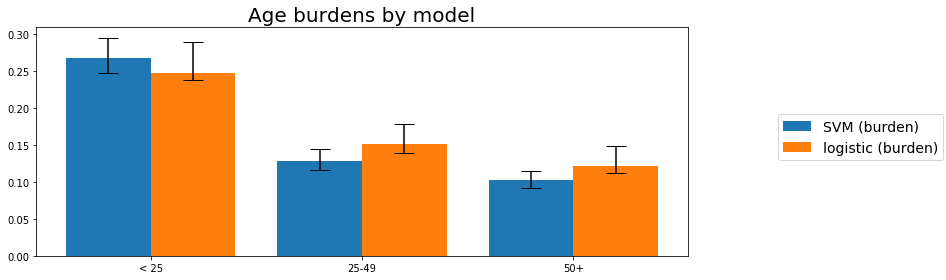

In [7]:
# Many scores also come with 95% confidence bounds, which we omitted above for the sake of brevity, but
# we can include those also.  In the example here we include the confidence bounds but only display the scores
# to a reduced level of detail to keep a smallish table for display purposes
df = construct_scores_dataframe(scores('fairness', result, max_depth=1))

display(df)

print("\n")

# Let's chart the fairness measure by age-group for each model together with its confidence bounds for
# easier visual comparison:
%matplotlib inline
import matplotlib.pyplot as plt

groups = ['< 25', '25-49', '50+']
feature_scores = df[[f"Group details ({g})" for g in groups]]
feature_lower_bounds = df[[f + ' lower bound' for f in feature_scores]]
feature_upper_bounds = df[[f + ' upper bound' for f in feature_scores]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Age burdens by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(groups))+width)
ax.set_xticklabels(groups)

for idx in range(len(df)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(groups))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()

## Conclusion

As we can see from the above chart, it's much harder for young people to achieve a high income than it is
for older cohorts.  This is not unexpected, but it's reassuring to see it confirmed.  It is also apparent that
the logistic model is giving slightly less biased results than is the SVM, and since both models had similar accuracy it would probably be our better choice here.